AssertionError: 0.7029339284896851

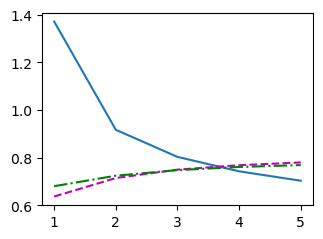

In [4]:
# 图像分类数据集
import torch
import torchvision
from IPython import display
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import time

# 记录运行时间的Timer类
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times)/len(self.times)

if __name__ == '__main__':
    # trans = transforms.ToTensor()
    # # 获取训练集
    # mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    # # 获取测试集
    # mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

    def get_fashion_mnist_labels(labels):
        text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'scandal', 'shirt', 'sneaker', 'bag',
                       'ankle boot']
        return [text_labels[int(i)] for i in labels]

    def show_images(imgs, num_rows, num_cols, titles=None, scales=1.5):
        figsize = (num_cols * scales, num_rows * scales)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        axes = axes.flatten()
        for i, (ax, img) in enumerate(zip(axes, imgs)):
            if torch.is_tensor(img):
                ax.imshow(img.numpy())
            else:
                ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if titles:
                ax.set_title(titles[i])
                ax.set_title(titles[i])
        plt.show()

    # X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
    # ax = show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))
    #
    # # 读取小批量
    # batch_size = 256

    def get_dataloader_workers():
        return 6

    def load_data_fashion_mnist(batch_size, resize = None):
        # 通过ToTensor实例将图像数据从PIL类型装换为32位浮点数类型
        trans = [transforms.ToTensor()]
        if resize:
            trans.insert(0, transforms.Resize(resize))
        trans = transforms.Compose(trans)
        mnist_train = torchvision.datasets.FashionMNIST(root = "../data", train = True, transform=trans, download=False)
        mnist_test = torchvision.datasets.FashionMNIST(root="../data", train = False, transform=trans, download=False)
        return (data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers()),
                data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers()))

    # 线性回归从零开始实现
    batch_size = 256
    train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

    num_inputs = 784
    num_outputs = 10
    w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
    b = torch.zeros(num_outputs, requires_grad=True)

    def softmax(X):
        X_exp = torch.exp(X)
        partition = X_exp.sum(1, keepdim=True)
        return X_exp / partition

    def net(X):
        return softmax(torch.mm(X.view((-1, w.shape[0])), w) + b)

    def cross_entropy(y_hat, y):
        return -torch.log(y_hat[range(len(y_hat)), y])

    def accuracy(y_hat, y):
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = y_hat.argmax(axis=1)
        cmp = y_hat.type(y.dtype) == y
        return float(cmp.type(y.dtype).sum())

    class Accumulator:
        def __init__(self, n):
            self.data = [0.0] * n

        def add(self, *args):
            self.data = [a + float(b) for a, b in zip(self.data, args)]

        def reset(self):
            self.data = [0.0] * len(self.data)

        def __getitem__(self, idx):
            return self.data[idx]

    def evaluate_accuracy(net, data_iter):
        if isinstance(net, torch.nn.Module):
            net.eval()
        metric = Accumulator(2)
        with torch.no_grad():
            for X, y in data_iter:
                metric.add(accuracy(net(X), y), y.numel())
        return metric[0]/metric[1]

    def train_epoch_ch3(net, train_iter, loss, updater):
        if isinstance(net, torch.nn.Module):
            net.train()
        metric = Accumulator(3)
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            if isinstance(updater, torch.optim.Optimizer):
                updater.zero_grad()
                l.backward()
                updater.step()
            else:
                l.sum().backward()
                updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        return metric[0]/metric[2], metric[1]/metric[2]

    class Animator:
        def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                     ylim=None, xscale='linear', yscale='linear',
                     fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                     figsize=(3.5, 2.5)):
            if legend is None:
                legend = []
            self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
            if nrows * ncols == 1:
                self.axes = [self.axes, ]
            self.config_axes = lambda: None
            self.config_axes()
            self.X, self.Y, self.fmts = None, None, fmts

        def add(self, x, y):
            if not hasattr(y, "__len__"):
                y = [y]
            n = len(y)
            if not hasattr(x, "__len__"):
                x = [x] * n
            if not self.X:
                self.X = [[] for _ in range(n)]
            if not self.Y:
                self.Y = [[] for _ in range(n)]
            for i, (a, b) in enumerate(zip(x, y)):
                if a is not None and b is not None:
                    self.X[i].append(a)
                    self.Y[i].append(b)
            self.axes[0].cla()
            for x, y, fmt in zip(self.X, self.Y, self.fmts):
                self.axes[0].plot(x, y, fmt)
            self.config_axes()
            display.display(self.fig)
            display.clear_output(wait=True)

    def train_ch3(net, train_iter,  test_iter, loss, num_epochs, updater):
        animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                            legend=['train loss', 'train acc', 'test acc'])
        for epoch in range(num_epochs):
            train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
            test_acc = evaluate_accuracy(net, test_iter)
            animator.add(epoch+1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
        assert train_loss < 0.5, train_loss
        assert train_acc <= 1 and train_acc > 0.7, train_acc
        assert test_acc <= 1 and test_acc > 0.7, test_acc

    def sgd(params, lr, batch_size):
        with torch.no_grad():
            for param in params:
                param.data -= lr * param.grad / batch_size
                param.grad.zero_()

    lr = 0.01
    def updater(batch_size):
        return sgd([w, b], lr, batch_size)

    num_epochs = 5
    train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [33]:
import numpy as np
a = [2]*5
b = (1, 3, 5, 2, 4)
for i, (aa, bb) in enumerate(zip(a, b)):
    print(aa, bb)

(2, 2, 2, 2, 2)
(1, 3, 5, 2, 4)
